In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int', 'preco_pon', 'qnt_soma']#, 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 500 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
l = n_variaveis-1
tam_janela = n_variaveis*janela
n_entradas = n_variaveis * janela + 2 #ncont, valor e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
lim_cont = 5
n_saidas = 2*lim_cont+1   #numero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
dias = 100

caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
inputs_nao_norm = arquivo[index_arquivo]
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0
n_steps = 106 #especifico pra 5min
for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = np.amax(hr)
batch = step_max + 1
print(inputs)
#normalizacao dos dados
hr = hr/step_max
inputs['hr_int'] = hr
pmean = np.mean( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor minimo do preco  #step = 106
pstd = np.std( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor maximo do preco
for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imean = np.mean( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor maximo
    istd = np.std( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor minimo
       
    inputs.loc[:, inputs.columns[i]] = inputs.loc[:, inputs.columns[i]] - imean 
    
mini_batch_size = int(dias*batch*0.1)

        preco    hr_int  preco_pon  qnt_soma
0      3907.5  32700000    3907.50       1.0
1      3900.0  33000000    3901.26   20309.0
2      3898.0  33300000    3901.42   17614.0
3      3898.0  33600000    3895.37   14283.0
4      3899.5  33900000    3897.78    6638.0
5      3906.0  34200000    3902.52   13485.0
6      3908.0  34500000    3907.20   12677.0
7      3913.0  34800000    3910.72   17927.0
8      3906.0  35100000    3909.27   18032.0
9      3902.0  35400000    3904.82   17600.0
10     3900.5  35700000    3900.53    9326.0
11     3894.0  36000000    3896.53   18013.0
12     3897.5  36300000    3897.41   14159.0
13     3900.0  36600000    3897.87    5793.0
14     3906.0  36900000    3902.17   15901.0
15     3907.5  37200000    3905.68   12928.0
16     3908.0  37500000    3908.40    7904.0
17     3911.0  37800000    3909.38    7750.0
18     3911.0  38100000    3912.43   10917.0
19     3908.5  38400000    3910.42    8978.0
20     3916.5  38700000    3913.49   12775.0
21     391

D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import backend as K            #importa backend para clear_session()


##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = 5
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria_dia()
        self.limpa_memoria_epoca()
        self.gamma = 0.98     # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-4
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []
        self.janela_precos = []
        self.prox_janela_precos = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(512, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(256, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(256, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(196, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)        
        model.add(Dense(128, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(64, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(32, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        
        #model.add(Dense(128, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        #model.add(Dense(x*3, activation='relu')) #camada escondida
        #model.add(Dense(x*2, activation='relu')) #camada escondida
        #model.add(Dense(x, activation='relu')) #camada escondida
        #model.add(Dense(64, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='linear')) #camada de saida
        model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        #sgd = optimizers.SGD(lr=self.learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        #model.compile(loss='mse', optimizer=sgd)
        return model

    def limpa_memoria_dia(self):
        self.janela_precos = np.zeros(n_variaveis*janela)
        self.prox_janela_precos = np.zeros(n_variaveis*janela)
        self.state = []
        self.next_state = []
    
    def limpa_memoria_epoca(self):
        self.memory = []
        
    def toma_acao(self):
        if np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria     
        act_values = self.model.predict(self.state) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=mini_batch_size):
        minibatch = random.sample(self.memory, batch_size) if dias>5 else self.memory
        
        x = []
        y = []
        for acao, reward, estado, prox_estado, done in minibatch:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(prox_estado)[0])) #pega valor que quer chegar
            
            target_f = self.model.predict(estado) 
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x.append(estado[0])
            y.append(target_f[0])
            
        self.model.fit(np.asarray(x), np.asarray(y), epochs=1, verbose=0) #treina modelo
        
    def tira_ultima_janela(self):
        if self.janela_precos.shape[0] > self.janela * self.n_variaveis:
            self.janela_precos = self.janela_precos[self.n_variaveis:] #tira os ultimos precos
    
    def remember(self, acao, reward, done):
        self.memory.append((acao, reward, self.state, self.next_state, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 196)               50372     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               25216     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [14]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont = acao #posicao atual = acao
    reward = 0.
    posicao = 0.
    dp = 0.

    
    #variaveis para tratamento do sinal de ncont, ncont_anterior e da acao
    acao = ncont - ncont_anterior  #ajuda a manter as condições anteriores
    var1 = ncont*ncont_anterior
    var2 = ncont*acao

    if acao != 0:
        #realizacao de lucros e custos
        if ((var2>0) and (var1>=0)):
            #aumento da posicao
            reward = -custo*abs(acao)    #reward = -custo*acao se houve operacao (aumento da posicao)
            #aumento da posicao = preco medio:
            valor = (ncont_anterior*valor + acao*preco)/ncont  
            
        else:
            valor_cheio = valor * pstd + pmean  #valores nao normalizados
            preco_cheio = preco * pstd + pmean
            if (var1)>= 0:
                #diminuicao da posicao
                reward = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
                #valor medio nao muda na diminuicao, somente se ncont==0:
                if ncont==0: valor=-10
                    
            else:
                #troca de posicao
                reward = (-ncont_anterior)*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve troca da posicao
                #preco medio da posicao = preco da troca de posicao
                valor = preco
    
    #definindo o lucro potencial da carteira(posicao)
    if valor!=-10:
        valor_cheio = valor * pstd + pmean  #valor posicionado atual      
        dp = (preco * pstd + pmean) - valor_cheio #variacao do preco atual e do preco de compra/venda
        posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (POTENCIAL)
        
    return ncont, valor, posicao, reward

def teste(preco, ncont, acao, valor, custo=0):   

    if acao == 0: #zerado
        if ncont>0:  #zerando
            reward = ncont*(preco-valor) -custo*abs(ncont)
        elif ncont<0: #zerando
            reward = ncont*(preco-valor) -custo*abs(ncont)
        else:         
            reward = 0
        valor = -100
    elif acao>0:  #comprado
        if ncont>0:
            if acao>ncont: #aumento da posicao
                reward = -custo*(acao-ncont)
                valor = (valor*ncont+(acao-ncont)*preco)/(acao)  #calculo preco medio
            elif acao<ncont:  #diminuicao da posicao
                reward = (ncont-acao)*(preco-valor) -custo*(ncont-acao)
                valor = valor #preco medio se mantem
            else:
                reward = 0
        elif ncont<0:   #trocando a mao
            reward = abs(ncont)*(valor-preco) -custo*(acao+abs(ncont))
            valor = preco
        else:          #saiu do zero
            reward = -custo*abs(acao)
            valor = preco
    else:       #vendido
        if ncont>0:#trocando a mao
            reward = ncont*(preco-valor) -custo*(ncont+abs(acao))
            valor = preco
        elif ncont<0:
            if abs(acao)<abs(ncont): #diminuicao da posicao
                reward = (abs(ncont)-abs(acao))*(valor-preco) -custo*(abs(ncont)-abs(acao))
                valor = valor #preco medio se mantem
            elif abs(acao)>abs(ncont): #aumento da posicao
                reward = -custo*(abs(acao)-abs(ncont))
                valor = (valor*abs(ncont)+(abs(acao)-abs(ncont))*preco)/(abs(acao))  #calculo preco medio
            else: #preco medio se mantem
                reward = 0
        else:  #saiu do zero
            reward = -custo*abs(acao)
            valor = preco
                
    #reward = ncont*acao*preco
    ncont = acao
    posicao = ncont*(preco-valor) -custo*abs(ncont) if ncont!=0 else 0.
    return ncont, reward, valor, posicao

def obter_acao():
    decisao = modelo.toma_acao() #calcula a saida da rede neural
    return (decisao - lim_cont)

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = -100 #cria variavel para preo medio
    reward = 0. #cria variavel para recompensa
    indice = 0
    lucro = 0.
    posicao = 0. #cria variavel de posicao 
    erro = []
    modelo.limpa_memoria_dia() #limpa o vetor de memoria
    done = False
    posicao_max = 1e4
    shp = modelo.janela_precos.shape
    
    for step in range( steps[dia], steps[dia+1] ):  #roda os dados
        
        modelo.state = np.reshape([ncont, indice, precos['preco'][step], valor, precos['preco_pon'][step]], (1,modelo.state_size))
        
        acao = obter_acao()
        ncont, reward, valor, posicao = teste(precos['preco'][step], ncont, acao, valor)
        
        #pos acao
        lucro += reward    #LUCRO ACUMULADO
        
        v=valor*pstd+pmean if valor!=-100 else 0
        p=precos['preco'][step]+pmean
        print("acao={0}; ncont={1}; reward={2} valor={3} preco={4}".format(acao, ncont, reward, valor, precos['preco'][step]))   

        if step == (steps[dia+1] - 1): #se ultimo step do dia
            done = True     
        
        modelo.next_state = np.reshape([ncont, indice+1, precos['preco'][step+1], valor, precos['preco_pon'][step+1]], (1,modelo.state_size))
        modelo.remember(acao, posicao, done)  #salva step na memoria - reward = lucro instantaneo que a ação gerou
        indice += 1
        
    #fim do dia
    lucro +=posicao
    
    #print("ncont zerados={0}; posicao={1}".format(ncont, posicao))
    if lucro > melhor_reward:
        melhor_reward = lucro
    return lucro #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo, dia_inicial, n_dias):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    
    for dia in range( dia_inicial, dia_inicial+n_dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards

indic = 0

def train_teste(batch_size=10):
        
        minibatch = modelo.memory
        
        x = []
        y = []
        for acao, reward, estado, prox_estado, done in minibatch:        
            target = reward
            if not done:
                target = (reward + modelo.gamma * np.amax(modelo.model.predict(prox_estado)[0])) #pega valor que quer chegar
            
            target_f = modelo.model.predict(estado)
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x.append(estado[0])
            y.append(target_f[0])
        
        modelo.model.fit(np.asarray(x), np.asarray(y), epochs=1, verbose=0) #treina modelo

W1115 13:27:07.617420  8196 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1115 13:27:15.445868  8196 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1115 13:27:15.485870  8196 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:438: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



resultado da epoca 0 = -1786.00 Epsilon = 1.000
resultado da epoca 1 = -126.50 Epsilon = 0.998
resultado da epoca 2 = 1094.50 Epsilon = 0.996
resultado da epoca 3 = -603.50 Epsilon = 0.994
resultado da epoca 4 = 596.00 Epsilon = 0.992
resultado da epoca 5 = -434.00 Epsilon = 0.990
resultado da epoca 6 = -290.50 Epsilon = 0.988
resultado da epoca 7 = 932.50 Epsilon = 0.986
resultado da epoca 8 = -2223.50 Epsilon = 0.984
resultado da epoca 9 = 1317.00 Epsilon = 0.982
resultado da epoca 10 = 548.00 Epsilon = 0.980
resultado da epoca 11 = -964.00 Epsilon = 0.978
resultado da epoca 12 = -586.50 Epsilon = 0.976
resultado da epoca 13 = -213.00 Epsilon = 0.974
resultado da epoca 14 = 155.50 Epsilon = 0.972
resultado da epoca 15 = -1438.50 Epsilon = 0.970
resultado da epoca 16 = 1411.50 Epsilon = 0.968
resultado da epoca 17 = 1208.50 Epsilon = 0.966
resultado da epoca 18 = 540.00 Epsilon = 0.964
resultado da epoca 19 = 208.00 Epsilon = 0.962
resultado da epoca 20 = -128.50 Epsilon = 0.960
resul

resultado da epoca 170 = 165.00 Epsilon = 0.663
resultado da epoca 171 = 883.00 Epsilon = 0.661
resultado da epoca 172 = 3218.00 Epsilon = 0.659
resultado da epoca 173 = 347.50 Epsilon = 0.657
resultado da epoca 174 = 629.00 Epsilon = 0.655
resultado da epoca 175 = -759.00 Epsilon = 0.654
resultado da epoca 176 = 2412.50 Epsilon = 0.652
resultado da epoca 177 = -484.50 Epsilon = 0.650
resultado da epoca 178 = 1193.00 Epsilon = 0.648
resultado da epoca 179 = -2489.00 Epsilon = 0.646
resultado da epoca 180 = -143.00 Epsilon = 0.644
resultado da epoca 181 = -660.50 Epsilon = 0.642
resultado da epoca 182 = 2701.50 Epsilon = 0.640
resultado da epoca 183 = 590.50 Epsilon = 0.638
resultado da epoca 184 = -2371.50 Epsilon = 0.636
resultado da epoca 185 = 500.00 Epsilon = 0.634
resultado da epoca 186 = 176.00 Epsilon = 0.632
resultado da epoca 187 = -487.50 Epsilon = 0.630
resultado da epoca 188 = 1928.00 Epsilon = 0.628
resultado da epoca 189 = 205.50 Epsilon = 0.626
resultado da epoca 190 = -

resultado da epoca 338 = -26.00 Epsilon = 0.331
resultado da epoca 339 = 1085.50 Epsilon = 0.329
resultado da epoca 340 = 2743.00 Epsilon = 0.327
resultado da epoca 341 = 1126.50 Epsilon = 0.325
resultado da epoca 342 = -523.00 Epsilon = 0.323
resultado da epoca 343 = -1782.00 Epsilon = 0.321
resultado da epoca 344 = 2072.00 Epsilon = 0.319
resultado da epoca 345 = 2479.00 Epsilon = 0.317
resultado da epoca 346 = 3568.50 Epsilon = 0.315
resultado da epoca 347 = 1110.50 Epsilon = 0.313
resultado da epoca 348 = -120.50 Epsilon = 0.311
resultado da epoca 349 = 1779.00 Epsilon = 0.309
resultado da epoca 350 = 750.00 Epsilon = 0.307
resultado da epoca 351 = 2956.50 Epsilon = 0.305
resultado da epoca 352 = 1637.50 Epsilon = 0.303
resultado da epoca 353 = -859.50 Epsilon = 0.301
resultado da epoca 354 = -643.50 Epsilon = 0.299
resultado da epoca 355 = -767.00 Epsilon = 0.297
resultado da epoca 356 = 521.50 Epsilon = 0.295
resultado da epoca 357 = 169.00 Epsilon = 0.293
resultado da epoca 358 

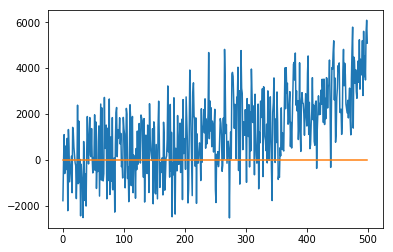

In [6]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    modelo.epsilon = 1.
    melhor_reward = 0
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
            
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            modelo.limpa_memoria_epoca()
            sum_rewards = rodar_dias(inputs, custo, 0, dias) #adiciona o resultado da epoca na somatoria
            train_teste() #roda o modelo com toda a memoria da epoca
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f} Epsilon = {2:0.3f}".format(epoca, sum_rewards, modelo.epsilon))
            #print(dias_pos)
            #print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0            
            if modelo.epsilon <= epsilon_min:
                modelo.epsilon = epsilon_min
            else:
                modelo.epsilon -= epsilon_decay
    finally:
        #print(dias_pos)
        #print(dias_neg)
        modelo.salva_pesos('./pesos_5.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
            
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca

In [15]:
modelo.epsilon = 0
print(rodar_dias(inputs, custo, 0, dias))

acao=-5; ncont=-5; reward=0 valor=27.997594566550106 preco=27.997594566550106
acao=-5; ncont=-5; reward=0 valor=27.997594566550106 preco=20.497594566550106
acao=-5; ncont=-5; reward=0 valor=27.997594566550106 preco=18.497594566550106
acao=-5; ncont=-5; reward=0 valor=27.997594566550106 preco=18.497594566550106
acao=-5; ncont=-5; reward=0 valor=27.997594566550106 preco=19.997594566550106
acao=-5; ncont=-5; reward=0 valor=27.997594566550106 preco=26.497594566550106
acao=5; ncont=5; reward=-2.5 valor=28.497594566550106 preco=28.497594566550106
acao=5; ncont=5; reward=0 valor=28.497594566550106 preco=33.497594566550106
acao=-5; ncont=-5; reward=-10.0 valor=26.497594566550106 preco=26.497594566550106
acao=-5; ncont=-5; reward=0 valor=26.497594566550106 preco=22.497594566550106
acao=-5; ncont=-5; reward=0 valor=26.497594566550106 preco=20.997594566550106
acao=-5; ncont=-5; reward=0 valor=26.497594566550106 preco=14.497594566550106
acao=-5; ncont=-5; reward=0 valor=26.497594566550106 preco=17

acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=40.997594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=37.997594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=36.497594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=36.497594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=34.497594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=34.997594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=32.497594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=33.497594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=34.497594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=35.997594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=33.497594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=34.497594566550106
acao=5; ncont=5; reward=0 valor=21.997594566550106 preco=34.997594566550106
acao=5; ncon

acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-10.502405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-15.002405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-13.502405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-11.502405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-11.002405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-17.002405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-11.502405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-12.002405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-12.002405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-12.002405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-12.502405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106 preco=-13.002405433449894
acao=-5; ncont=-5; reward=0 valor=10.497594566550106

acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=11.997594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=12.497594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=12.497594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=11.497594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=11.997594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=12.497594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=12.997594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=8.997594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=8.997594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=6.997594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=6.997594566550106
acao=5; ncont=5; reward=0 valor=-27.002405433449894 preco=10.997594566550106
acao=-5; ncont=-5; reward=0 valor=19.497594566550106 preco=19.497594566550106
ac

acao=-5; ncont=-5; reward=-12.5 valor=-19.002405433449894 preco=-19.002405433449894
acao=5; ncont=5; reward=-2.5 valor=-18.502405433449894 preco=-18.502405433449894
acao=-5; ncont=-5; reward=-12.5 valor=-21.002405433449894 preco=-21.002405433449894
acao=5; ncont=5; reward=-7.5 valor=-19.502405433449894 preco=-19.502405433449894
acao=5; ncont=5; reward=0 valor=-19.502405433449894 preco=-16.502405433449894
acao=5; ncont=5; reward=0 valor=-19.502405433449894 preco=-17.502405433449894
acao=5; ncont=5; reward=0 valor=-19.502405433449894 preco=-18.502405433449894
acao=5; ncont=5; reward=0 valor=-19.502405433449894 preco=-20.002405433449894
acao=-5; ncont=-5; reward=-35.0 valor=-26.502405433449894 preco=-26.502405433449894
acao=-5; ncont=-5; reward=0 valor=-26.502405433449894 preco=-27.002405433449894
acao=5; ncont=5; reward=-7.5 valor=-25.002405433449894 preco=-25.002405433449894
acao=-5; ncont=-5; reward=-17.5 valor=-28.502405433449894 preco=-28.502405433449894
acao=-5; ncont=-5; reward=0 v

acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-97.5024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-97.0024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-94.5024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-92.0024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-94.5024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-94.5024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-94.5024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-95.0024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-96.5024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-94.0024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-93.0024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-94.5024054334499
acao=-5; ncont=-5; reward=0 valor=-76.5024054334499 preco=-96.5024054334499
acao=-5; nco

acao=5; ncont=5; reward=0 valor=-160.5024054334499 preco=-162.0024054334499
acao=-5; ncont=-5; reward=-17.5 valor=-164.0024054334499 preco=-164.0024054334499
acao=5; ncont=5; reward=-7.5 valor=-162.5024054334499 preco=-162.5024054334499
acao=5; ncont=5; reward=0 valor=-162.5024054334499 preco=-162.5024054334499
acao=5; ncont=5; reward=0 valor=-162.5024054334499 preco=-163.0024054334499
acao=5; ncont=5; reward=0 valor=-162.5024054334499 preco=-158.5024054334499
acao=5; ncont=5; reward=0 valor=-162.5024054334499 preco=-162.0024054334499
acao=5; ncont=5; reward=0 valor=-162.5024054334499 preco=-162.5024054334499
acao=-5; ncont=-5; reward=-27.5 valor=-168.0024054334499 preco=-168.0024054334499
acao=5; ncont=5; reward=2.5 valor=-168.5024054334499 preco=-168.5024054334499
acao=-5; ncont=-5; reward=-10.0 valor=-170.5024054334499 preco=-170.5024054334499
acao=-5; ncont=-5; reward=0 valor=-170.5024054334499 preco=-174.0024054334499
acao=5; ncont=5; reward=7.5 valor=-172.0024054334499 preco=-172

acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-165.0024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-164.0024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-163.0024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-160.5024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-163.5024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-161.5024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-161.5024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-162.0024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-162.0024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-161.5024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-161.5024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-163.5024054334499
acao=5; ncont=5; reward=0 valor=-170.0024054334499 preco=-163.5024054334499
acao=5; ncon

acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-125.5024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-118.0024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-122.5024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-121.5024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-124.0024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-111.5024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-114.0024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-110.0024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-111.5024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-115.0024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-110.5024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-111.5024054334499
acao=5; ncont=5; reward=0 valor=-161.5024054334499 preco=-109.0024054334499
acao=5; ncon

acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-30.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-26.502405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-27.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-28.502405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-25.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-21.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-22.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-19.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-20.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-15.502405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-18.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-16.002405433449894
acao=5; ncont=5; reward=0 valor=-34.502405433449894 preco=-15.50

acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=28.497594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=32.997594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=34.497594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=29.497594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=26.497594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=27.497594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=30.997594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=30.497594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=33.497594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=34.997594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=31.997594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=29.997594566550106
acao=-5; ncont=-5; reward=0 valor=36.997594566550106 preco=26.99

acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=45.997594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=47.497594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=49.997594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=52.497594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=54.997594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=52.497594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=50.497594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=49.497594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=47.997594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=46.497594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=42.997594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=42.497594566550106
acao=-5; ncont=-5; reward=0 valor=67.9975945665501 preco=44.497594566550106
acao=-5; nco

acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=205.4975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=200.9975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=204.9975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=209.4975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=205.4975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=206.4975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=200.4975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=202.9975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=204.9975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=202.9975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=200.9975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=199.4975945665501
acao=5; ncont=5; reward=0 valor=174.9975945665501 preco=199.9975945665501
acao=5; ncont=5; reward=0 valor=174.99

acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=202.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=201.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=201.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=197.9975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=195.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=197.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=192.9975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=193.9975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=187.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=186.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=181.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=188.4975945665501
acao=-5; ncont=-5; reward=0 valor=228.9975945665501 preco=183.4975945665501
acao=-5; nco

acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=239.4975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=239.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=239.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=241.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=240.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=241.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=241.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=241.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=239.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=239.4975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=235.9975945665501
acao=-5; ncont=-5; reward=0 valor=278.9975945665501 preco=232.9975945665501
acao=-5; ncont=-5; reward=0 valor=248.4975945665501 preco=248.4975945665501
acao=5; ncon

acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=259.9975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=260.9975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=258.9975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=258.4975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=260.4975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=260.9975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=262.4975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=261.9975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=261.4975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=260.9975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=258.9975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=264.9975945665501
acao=5; ncont=5; reward=0 valor=239.9975945665501 preco=263.4975945665501
acao=5; ncont=5; reward=0 valor=239.99

acao=5; ncont=5; reward=0 valor=277.9975945665501 preco=286.4975945665501
acao=5; ncont=5; reward=0 valor=277.9975945665501 preco=281.9975945665501
acao=5; ncont=5; reward=0 valor=277.9975945665501 preco=286.4975945665501
acao=5; ncont=5; reward=0 valor=277.9975945665501 preco=285.9975945665501
acao=5; ncont=5; reward=0 valor=277.9975945665501 preco=286.4975945665501
acao=5; ncont=5; reward=0 valor=277.9975945665501 preco=283.4975945665501
acao=5; ncont=5; reward=0 valor=277.9975945665501 preco=282.4975945665501
acao=-5; ncont=-5; reward=-2.5 valor=277.4975945665501 preco=277.4975945665501
acao=-5; ncont=-5; reward=0 valor=277.4975945665501 preco=274.9975945665501
acao=-5; ncont=-5; reward=0 valor=277.4975945665501 preco=271.9975945665501
acao=-5; ncont=-5; reward=0 valor=277.4975945665501 preco=274.4975945665501
acao=-5; ncont=-5; reward=0 valor=277.4975945665501 preco=277.9975945665501
acao=-5; ncont=-5; reward=0 valor=277.4975945665501 preco=273.9975945665501
acao=-5; ncont=-5; rewa

acao=-5; ncont=-5; reward=0 valor=263.9975945665501 preco=263.9975945665501
acao=-5; ncont=-5; reward=0 valor=263.9975945665501 preco=254.9975945665501
acao=-5; ncont=-5; reward=0 valor=263.9975945665501 preco=257.9975945665501
acao=5; ncont=5; reward=-15.0 valor=266.9975945665501 preco=266.9975945665501
acao=-5; ncont=-5; reward=-5.0 valor=265.9975945665501 preco=265.9975945665501
acao=-5; ncont=-5; reward=0 valor=265.9975945665501 preco=254.9975945665501
acao=-5; ncont=-5; reward=0 valor=265.9975945665501 preco=248.4975945665501
acao=-5; ncont=-5; reward=0 valor=265.9975945665501 preco=248.9975945665501
acao=-5; ncont=-5; reward=0 valor=265.9975945665501 preco=251.9975945665501
acao=-5; ncont=-5; reward=0 valor=265.9975945665501 preco=246.4975945665501
acao=-5; ncont=-5; reward=0 valor=265.9975945665501 preco=250.4975945665501
acao=-5; ncont=-5; reward=0 valor=265.9975945665501 preco=250.9975945665501
acao=-5; ncont=-5; reward=0 valor=265.9975945665501 preco=251.4975945665501
acao=-5

acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=294.4975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=298.9975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=302.4975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=304.9975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=300.4975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=290.4975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=288.4975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=290.4975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=295.9975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=297.9975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=297.4975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=290.9975945665501
acao=-5; ncont=-5; reward=0 valor=311.9975945665501 preco=285.9975945665501
acao=-5; nco

acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=159.9975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=163.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=162.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=165.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=167.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=168.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=169.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=167.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=167.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=166.4975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=169.9975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=163.9975945665501
acao=-5; ncont=-5; reward=0 valor=207.9975945665501 preco=168.9975945665501
acao=-5; nco

acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=166.4975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=168.9975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=163.9975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=166.9975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=164.4975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=155.4975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=157.4975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=157.9975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=156.9975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=152.4975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=146.9975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=147.9975945665501
acao=-5; ncont=-5; reward=0 valor=185.4975945665501 preco=152.9975945665501
acao=-5; nco

acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=9.497594566550106
acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=8.997594566550106
acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=7.997594566550106
acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=15.997594566550106
acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=19.997594566550106
acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=16.997594566550106
acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=19.997594566550106
acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=23.497594566550106
acao=5; ncont=5; reward=0 valor=-38.502405433449894 preco=25.497594566550106
acao=-5; ncont=-5; reward=0 valor=43.497594566550106 preco=43.497594566550106
acao=-5; ncont=-5; reward=0 valor=43.497594566550106 preco=39.497594566550106
acao=5; ncont=5; reward=-32.5 valor=49.997594566550106 preco=49.997594566550106
acao=-5; ncont=-5; reward=25.0 valor=54.997594566550106 preco=54.997594566

acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-117.0024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-114.5024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-114.5024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-107.5024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-110.5024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-114.5024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-115.5024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-116.5024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-115.0024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-111.0024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-113.0024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-120.5024054334499
acao=5; ncont=5; reward=0 valor=-144.5024054334499 preco=-123.0024054334499
acao=5; ncon

acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-122.0024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-118.5024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-119.0024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-116.5024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-119.0024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-119.5024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-111.0024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-110.0024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-116.0024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-116.0024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-107.0024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-105.5024054334499
acao=5; ncont=5; reward=0 valor=-149.0024054334499 preco=-111.0024054334499
acao=5; ncon

acao=5; ncont=5; reward=0 valor=-176.5024054334499 preco=-153.5024054334499
acao=5; ncont=5; reward=0 valor=-139.5024054334499 preco=-139.5024054334499
acao=-5; ncont=-5; reward=-12.5 valor=-142.0024054334499 preco=-142.0024054334499
acao=5; ncont=5; reward=-15.0 valor=-139.0024054334499 preco=-139.0024054334499
acao=-5; ncont=-5; reward=-32.5 valor=-145.5024054334499 preco=-145.5024054334499
acao=5; ncont=5; reward=7.5 valor=-147.0024054334499 preco=-147.0024054334499
acao=-5; ncont=-5; reward=-22.5 valor=-151.5024054334499 preco=-151.5024054334499
acao=5; ncont=5; reward=12.5 valor=-154.0024054334499 preco=-154.0024054334499
acao=-5; ncont=-5; reward=-12.5 valor=-156.5024054334499 preco=-156.5024054334499
acao=5; ncont=5; reward=-17.5 valor=-153.0024054334499 preco=-153.0024054334499
acao=-5; ncont=-5; reward=-27.5 valor=-158.5024054334499 preco=-158.5024054334499
acao=5; ncont=5; reward=-7.5 valor=-157.0024054334499 preco=-157.0024054334499
acao=5; ncont=5; reward=0 valor=-157.00240

acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-170.0024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-169.5024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-170.0024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-174.0024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-174.5024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-172.5024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-171.5024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-169.0024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-164.5024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-165.0024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-163.5024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-164.5024054334499
acao=5; ncont=5; reward=0 valor=-178.0024054334499 preco=-165.5024054334499
acao=5; ncon

acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-158.0024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-162.5024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-159.0024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-161.0024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-162.0024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-159.0024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-158.5024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-156.0024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-153.0024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-153.0024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-155.5024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-155.5024054334499
acao=5; ncont=5; reward=0 valor=-193.5024054334499 preco=-152.0024054334499
acao=5; ncon

acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-250.5024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-244.0024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-241.0024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-244.0024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-245.5024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-241.5024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-251.0024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-252.0024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-252.5024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-253.0024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-249.0024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-252.0024054334499
acao=5; ncont=5; reward=0 valor=-295.5024054334499 preco=-248.5024054334499
acao=5; ncon

acao=5; ncont=5; reward=0 valor=-177.0024054334499 preco=-143.0024054334499
acao=5; ncont=5; reward=0 valor=-177.0024054334499 preco=-142.0024054334499
acao=5; ncont=5; reward=0 valor=-177.0024054334499 preco=-141.5024054334499
acao=5; ncont=5; reward=0 valor=-177.0024054334499 preco=-141.0024054334499
acao=5; ncont=5; reward=0 valor=-177.0024054334499 preco=-145.0024054334499
acao=5; ncont=5; reward=0 valor=-177.0024054334499 preco=-142.0024054334499
acao=5; ncont=5; reward=0 valor=-177.0024054334499 preco=-142.0024054334499
acao=5; ncont=5; reward=0 valor=-177.0024054334499 preco=-141.5024054334499
acao=5; ncont=5; reward=0 valor=-173.0024054334499 preco=-173.0024054334499
acao=5; ncont=5; reward=0 valor=-173.0024054334499 preco=-173.0024054334499
acao=5; ncont=5; reward=0 valor=-173.0024054334499 preco=-168.0024054334499
acao=5; ncont=5; reward=0 valor=-173.0024054334499 preco=-173.5024054334499
acao=-5; ncont=-5; reward=-35.0 valor=-180.0024054334499 preco=-180.0024054334499
acao=5

acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-122.5024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-124.0024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-130.5024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-129.0024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-128.0024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-130.5024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-128.5024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-128.0024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-133.5024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-129.5024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-126.5024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-124.5024054334499
acao=5; ncont=5; reward=0 valor=-141.0024054334499 preco=-128.0024054334499
acao=5; ncon

acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-129.5024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-126.5024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-129.0024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-129.0024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-128.5024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-125.0024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-126.0024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-126.0024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-125.0024054334499
acao=-5; ncont=-5; reward=0 valor=-121.5024054334499 preco=-124.5024054334499
acao=5; ncont=5; reward=5.0 valor=-122.5024054334499 preco=-122.5024054334499
acao=5; ncont=5; reward=0 valor=-122.5024054334499 preco=-120.5024054334499
acao=5; ncont=5; reward=0 valor=-122.5024054334499 preco=-119.0024

acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-62.002405433449894
acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-61.002405433449894
acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-59.002405433449894
acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-60.502405433449894
acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-59.002405433449894
acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-61.502405433449894
acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-64.5024054334499
acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-70.0024054334499
acao=-5; ncont=-5; reward=-7.5 valor=-72.0024054334499 preco=-72.0024054334499
acao=5; ncont=5; reward=-7.5 valor=-70.5024054334499 preco=-70.5024054334499
acao=5; ncont=5; reward=0 valor=-70.5024054334499 preco=-68.5024054334499
acao=-5; ncont=-5; reward=-17.5 valor=-74.0024054334499 preco=-74.0024054334499
acao=5; ncont=5; reward=2.5 valor=-74.5024054334499 preco=-74.5024054334499
acao=-5; n

acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-114.5024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-115.0024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-114.5024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-114.0024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-114.5024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-114.0024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-114.5024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-116.0024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-118.5024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-117.5024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-117.0024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-116.0024054334499
acao=5; ncont=5; reward=0 valor=-131.5024054334499 preco=-115.5024054334499
acao=-5; nco

acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-62.502405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-60.502405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-61.002405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-62.002405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-60.502405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-56.502405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-55.002405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-57.502405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-60.502405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-57.502405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-57.002405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-49.502405433449894
acao=5; ncont=5; reward=0 valor=-73.5024054334499 preco=-52.502405433449894
acao=5; ncon

acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-19.502405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-20.502405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-19.502405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-21.002405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-16.002405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-13.502405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-11.502405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-11.502405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-6.502405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-7.002405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-4.502405433449894
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-1.0024054334498942
acao=5; ncont=5; reward=0 valor=-26.002405433449894 preco=-2.502405

acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-47.002405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-36.502405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-37.002405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-32.502405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-37.002405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-38.002405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-40.002405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-40.502405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-41.002405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-41.502405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-38.502405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-39.002405433449894
acao=5; ncont=5; reward=0 valor=-53.002405433449894 preco=-40.00

acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-11.002405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-11.502405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-7.502405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-6.002405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-5.502405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-8.002405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-7.502405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-8.502405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-8.002405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-10.002405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-8.002405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-9.502405433449894
acao=5; ncont=5; reward=0 valor=-36.502405433449894 preco=-11.50240543344

In [10]:
modelo.epsilon = 0
rodar_dias(inputs, custo, 100, 20)


1044.5

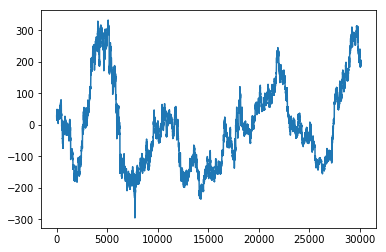

In [11]:
plt.plot(range(0,len(inputs)), inputs['preco'])

In [ ]:
plt.plot(range(0,len(inputs_nao_norm)), inputs_nao_norm['preco'])

In [13]:
np.amin(inputs['preco'])

-295.5024054334499

In [ ]:
pmean

In [ ]:
(4200-pmean)/pstd

In [ ]:
np.std(inputs_nao_norm['preco'])